In [1]:
#REFERENCE:https://github.com/MorvanZhou/Tensorflow-Tutorial

!rm -rf ./log
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import PIL
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

imageBigDataORL = np.zeros((400, 112*92))
YBigData = np.zeros(400)

def data_prep_ORL():
    for people in range(1,41):
        for face in range(1,11):
            path = './ORL/s%d_%d.bmp' % (people, face)
            oriImage = PIL.Image.open(path)
            imageArray = np.array(oriImage)
#             print(imageArray)
            imageVec = np.reshape(imageArray, imageArray.shape[0] * imageArray.shape[1])
            # print(imageArray.shape)
            # print(imageBigDataORL.shape)
#             print((people - 1) * 10 + face)
            imageBigDataORL[(people - 1) * 10 + face - 1] = imageVec
            YBigData[(people - 1) * 10 + face - 1] = people - 1 
#             print(imageBigDataORL)

def get_batch(size):
    index = np.random.randint(0, np.shape(X_train)[0], size)
    return X_train[index, :], Y_train[index]


In [2]:
data_prep_ORL()
X_train, X_test, Y_train, Y_test = train_test_split(imageBigDataORL, YBigData, test_size=0.3, random_state=42)


# with tf.variable_scope('Inputs'):
#     tf_x = tf.placeholder(tf.float32, x.shape, name='x')
#     tf_y = tf.placeholder(tf.float32, y.shape, name='y')

# with tf.variable_scope('Net'):
#     l1 = tf.layers.dense(tf_x, 10, tf.nn.relu, name='hidden_layer')
#     output = tf.layers.dense(l1, 1, name='output_layer')

with tf.variable_scope('Inputs'):
    tf_x = tf.placeholder(tf.float32, [None, X_train.shape[1]])     # input x
    tf_y = tf.placeholder(tf.int32, [None])     # input y

# neural network layers
with tf.variable_scope('Net'):
    l1 = tf.layers.dense(tf_x, 400, tf.nn.relu, name='hidden_layer_1')          # hidden layer
    l2 = tf.layers.dense(l1, 400, tf.nn.relu, name='hidden_layer_2')
    output = tf.layers.dense(l2, 40, name='output_layer')  # output layer
    tf.summary.histogram('h1_out', l1)
    tf.summary.histogram('h2_out', l2)
    tf.summary.histogram('pred', output)


global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.0001
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,100000, 0.96, staircase=True)

loss = tf.losses.sparse_softmax_cross_entropy(labels=tf_y, logits=output)   # compute cost
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)
accuracy = tf.metrics.accuracy(          # return (acc, update_op), and create 2 local variables
    labels=tf.squeeze(tf_y), predictions=tf.argmax(output, axis=1),)[1]
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
# train_op = optimizer.minimize(loss)
tf.summary.scalar('loss', loss)     # add loss to scalar summary
tf.summary.scalar('acc', accuracy)

sess = tf.Session()
# control training and others
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)     # initialize var in graph

writer = tf.summary.FileWriter('./log', sess.graph)     # write to file
merge_op = tf.summary.merge_all()                       # operation to merge all summary


for step in range(600):
    # train and net output
    _, acc, pred,result = sess.run([train_op, accuracy, output, merge_op], {tf_x: X_train, tf_y: Y_train})
    writer.add_summary(result, step)
#     print('steps:' , step, acc)

In [3]:
predictions=tf.argmax(output, axis=1)
acc, pred, onehot_predictions = sess.run([accuracy, output,predictions], {tf_x: X_test, tf_y: Y_test})
print('test accuracy:', acc)
print(pred)
print(onehot_predictions)


test accuracy: 0.92535096
[[  7.6557083  -26.643274    39.54988    ...  31.599426    44.311234
   28.565248  ]
 [  4.5740967  -22.808123    27.307648   ...  20.355663    25.124586
   41.754704  ]
 [ 30.241592    14.713658    22.108803   ...  28.507114    -5.4791665
   44.741432  ]
 ...
 [ 15.021873    -5.5556726   33.537125   ...   7.809269   -13.120612
   49.63234   ]
 [-13.737968    13.306342    30.90953    ...  24.627583    51.606247
    0.86570364]
 [  9.932167   -27.544481    23.140442   ...  13.129982     7.2341475
   49.584286  ]]
[20 29  3 21 31  8 32  9 30 12 17 27  5  7 13  4 27 37 23 38  7  1 39 36
  0  4  3 28 18 10 39 19  1  5 19  3  7 34 15 14 38  5  6 16  8 38 34 18
  2 17  4 32 33  7 37 22 22 17 34 15 12 29  2  7 10  3 35 26  2 21 23 14
  0  4  6 24 22 13 17 28 17  1 38 25 36  6  3 30 10  9 23 33  8 37 26 31
 20 34 19  7 24 11  0  6 27  0 23 13  8  4 13  6 29  6 29  6  8 28 30 39]


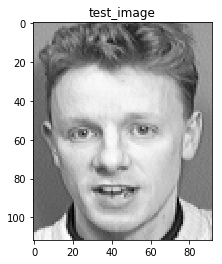

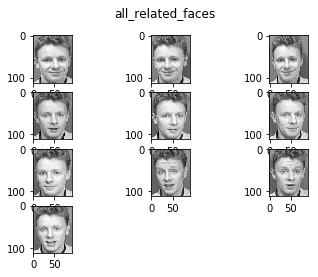

In [4]:
from IPython.display import Image
test_people = 0
face = X_test[test_people,:]
face_reshaped = np.reshape(face, [112, 92])
plt.figure()
plt.title('test_image')
plt.imshow(face_reshaped,cmap='Greys_r')
person = onehot_predictions[test_people]
plt.figure()
plt.suptitle('all_related_faces')
for faceNumber in range(1,11):
    path = './ORL/s%d_%d.bmp' % (person + 1, faceNumber)
    oriImage = PIL.Image.open(path)
    imageArray = np.array(oriImage)
    plt.subplot(4,3,faceNumber)
    plt.imshow(imageArray,cmap='Greys_r')

In [ ]:
! tensorboard --logdir ./log

TensorBoard 1.9.0 at http://KhazeusMBP.local:6006 (Press CTRL+C to quit)
